In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([test_df,df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [2]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [3]:
submission_file_name = "submission_kernel02.csv"
with timer("Full model run"):
    df = main()

df

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 26)
Process installments payments - done in 20s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 11s
Full model run - done in 80s


index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0            0      100001            0             0                0   
1            1      100005            1             0                0   
2            2      100013            1             1                0   
3            3      100028            0             0                0   
4            4      100038            1             1                1   
...        ...         ...          ...           ...              ...   
356250  307506      456251            1             0                1   
356251  307507      456252            0             0                0   
356252  307508      456253            0             0                0   
356253  307509      456254            0             0                0   
356254  307510      456255            0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          135000.0    568800.0      20560.5   
1                  0           99000.0    222768.0      17370.0   
2                  0          202500.0    663264.0      69777.0   
3                  2          315000.0   1575000.0      49018.5   
4                  1          180000.0    625500.0      32067.0   
...              ...               ...         ...          ...   
356250             0          157500.0    254700.0      27558.0   
356251             0           72000.0    269550.0      12001.5   
356252             0          153000.0    677664.0      29979.0   
356253             0          171000.0    370107.0      20205.0   
356254             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0              450000.0  ...                                 NaN   
1              180000.0  ...                                 NaN   
2              630000.0  ...                               False   
3             1575000.0  ...                               False   
4              625500.0  ...                                 NaN   
...                 ...  ...                                 ...   
356250         225000.0  ...                                 NaN   
356251         225000.0  ...                                 NaN   
356252         585000.0  ...                                 NaN   
356253         319500.0  ...                                 NaN   
356254         675000.0  ...                                 NaN   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                       NaN   
1                                       NaN   
2                                       0.0   
3                                       0.0   
4                                       NaN   
...                                     ...   
356250                                  NaN   
356251                                  NaN   
356252                                  NaN   
356253                                  NaN   
356254                                  NaN   

        CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                      NaN   
1                                      NaN   
2                                      0.0   
3                                      0.0   
4                                      NaN   
...                                    ...   
356250                                 NaN   
356251                                 NaN   
356252                                 NaN   
356253                                 NaN   
356254                                 NaN   

        CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                      NaN                              NaN   
1                                      NaN                              NaN   
2                                      0.0                            False   
3                                      0.0                      

In [4]:
pd.set_option('display.max_columns', None)
df

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0            0      100001            0             0                0   
1            1      100005            1             0                0   
2            2      100013            1             1                0   
3            3      100028            0             0                0   
4            4      100038            1             1                1   
...        ...         ...          ...           ...              ...   
356250  307506      456251            1             0                1   
356251  307507      456252            0             0                0   
356252  307508      456253            0             0                0   
356253  307509      456254            0             0                0   
356254  307510      456255            0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          135000.0    568800.0      20560.5   
1                  0           99000.0    222768.0      17370.0   
2                  0          202500.0    663264.0      69777.0   
3                  2          315000.0   1575000.0      49018.5   
4                  1          180000.0    625500.0      32067.0   
...              ...               ...         ...          ...   
356250             0          157500.0    254700.0      27558.0   
356251             0           72000.0    269550.0      12001.5   
356252             0          153000.0    677664.0      29979.0   
356253             0          171000.0    370107.0      20205.0   
356254             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              450000.0                    0.018850      -19241   
1              180000.0                    0.035792      -18064   
2              630000.0                    0.019101      -20038   
3             1575000.0                    0.026392      -13976   
4              625500.0                    0.010032      -13040   
...                 ...                         ...         ...   
356250         225000.0                    0.032561       -9327   
356251         225000.0                    0.025164      -20775   
356252         585000.0                    0.005002      -14966   
356253         319500.0                    0.005313      -11961   
356254         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0             -2329.0            -5170.0             -812          NaN   
1             -4469.0            -9118.0            -1623          NaN   
2             -4458.0            -2175.0            -3503          5.0   
3             -1866.0            -2000.0            -4208          NaN   
4             -2191.0            -4000.0            -4262         16.0   
...               ...                ...              ...          ...   
356250         -236.0            -8456.0            -1982          NaN   
356251            NaN            -4388.0            -4090          NaN   
356252        -7921.0            -6737.0            -5150          NaN   
356253        -4786.0            -2562.0             -931          NaN   
356254        -1262.0            -5128.0             -410          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                0                 1   
3                1               1                0                 1   
4                1               1                1                 1   
...            ...             ...              ...               ...   
356250           1               1                0                 1   
356251           1               0   

# ETUDE DES DONNEES

## Données manquantes

In [5]:
# Données manquantes

# Étape 1: Calculer le pourcentage de valeurs manquantes pour chaque colonne
Datanull = df.isnull()
SommeDatanull = Datanull.sum()
DatanullPourcentage = (SommeDatanull / len(df)) * 100

# Pourcentage de données manquantes sur notre target à mesurer (1 = difficulté / 0 = pas de problème)
print("Pourcentage de données manquantes sur la cible :")
print(DatanullPourcentage['TARGET'])


Pourcentage de données manquantes sur la cible :
13.682487908805872


In [6]:
# Enlever les données manquantes de la cible
df2 = df.dropna(subset=['TARGET'])

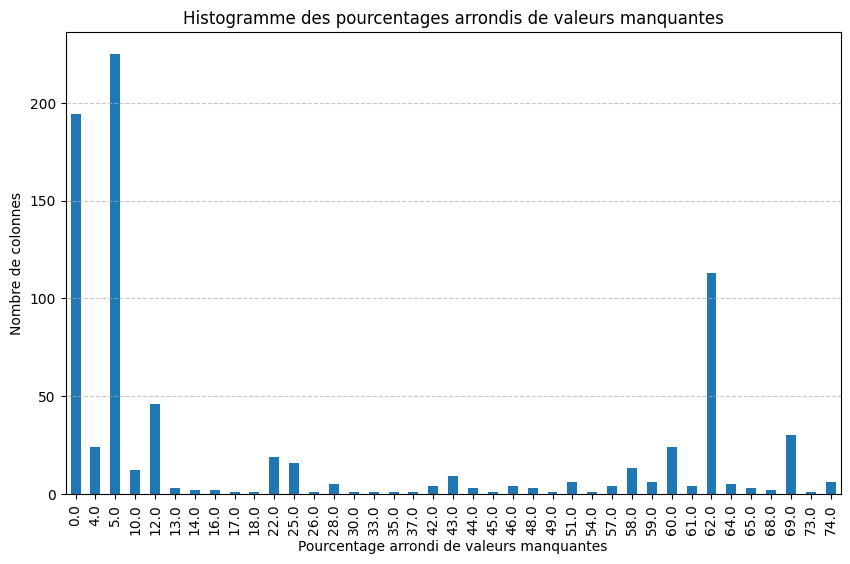

In [7]:
# Tableau pour représenter les valeurs manquantes 

# Refaire Étape 1: Calculer le pourcentage de valeurs manquantes pour chaque colonne
Datanull = df2.isnull()
SommeDatanull = Datanull.sum()
DatanullPourcentage = (SommeDatanull / len(df)) * 100

# Arrondir les valeurs à l'entier
DatanullPourcentage_arrondi = DatanullPourcentage.round()

# Compter les occurrences de chaque pourcentage arrondi de valeurs manquantes
Visu_manquant = DatanullPourcentage_arrondi.value_counts()

# Trier les valeurs par index (pourcentage arrondi) et réindexer
Visu_manquant = Visu_manquant.sort_index()

# Créer l'histogramme
plt.figure(figsize=(10, 6))
Visu_manquant.plot(kind='bar')
plt.title("Histogramme des pourcentages arrondis de valeurs manquantes")
plt.xlabel("Pourcentage arrondi de valeurs manquantes")
plt.ylabel("Nombre de colonnes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Étape 2: Identifier les colonnes avec plus de 20% de valeurs manquantes
colonnes_del = DatanullPourcentage[DatanullPourcentage > 20].index.tolist()

# Étape 3: Exclure ces colonnes du DataFrame
base_etude = df2.drop(columns=colonnes_del)
base_etude

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
48744        0      100002            1             0                0   
48745        1      100003            0             0                1   
48746        2      100004            1             1                0   
48747        3      100006            0             0                0   
48748        4      100007            1             0                0   
...        ...         ...          ...           ...              ...   
356250  307506      456251            1             0                1   
356251  307507      456252            0             0                0   
356252  307508      456253            0             0                0   
356253  307509      456254            0             0                0   
356254  307510      456255            0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
48744              0          202500.0    406597.5      24700.5   
48745              0          270000.0   1293502.5      35698.5   
48746              0           67500.0    135000.0       6750.0   
48747              0          135000.0    312682.5      29686.5   
48748              0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          157500.0    254700.0      27558.0   
356251             0           72000.0    269550.0      12001.5   
356252             0          153000.0    677664.0      29979.0   
356253             0          171000.0    370107.0      20205.0   
356254             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
48744          351000.0                    0.018801       -9461   
48745         1129500.0                    0.003541      -16765   
48746          135000.0                    0.010032      -19046   
48747          297000.0                    0.008019      -19005   
48748          513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
356250         225000.0                    0.032561       -9327   
356251         225000.0                    0.025164      -20775   
356252         585000.0                    0.005002      -14966   
356253         319500.0                    0.005313      -11961   
356254         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
48744          -637.0            -3648.0            -2120           1   
48745         -1188.0            -1186.0             -291           1   
48746          -225.0            -4260.0            -2531           1   
48747         -3039.0            -9833.0            -2437           1   
48748         -3038.0            -4311.0            -3458           1   
...               ...                ...              ...         ...   
356250         -236.0            -8456.0            -1982           1   
356251            NaN            -4388.0            -4090           1   
356252        -7921.0            -6737.0            -5150           1   
356253        -4786.0            -2562.0             -931           1   
356254        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
48744                1                0                 1           1   
48745                1                0                 1           1   
48746                1                1                 1           1   
48747                1                0                 1           0   
48748                1                0                 1           0   
...                ...              ...               ...         ...   
356250               1                0                 1           0   
356251               0                0          

In [9]:
# column_names = list(df.columns)
# column_names
# df_selection = df[['SK_ID_CURR','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','OWN_CAR_AGE','CNT_FAM_MEMBERS','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION',
# 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','APARTMENTS_AVG',
# 'BASEMENTAREA_AVG',
# 'YEARS_BEGINEXPLUATATION_AVG',
# 'YEARS_BUILD_AVG', 'AMT_REQ_CREDIT_BUREAU_HOUR',
# 'AMT_REQ_CREDIT_BUREAU_DAY',
# 'AMT_REQ_CREDIT_BUREAU_WEEK',
# 'AMT_REQ_CREDIT_BUREAU_MON',
# 'AMT_REQ_CREDIT_BUREAU_QRT',
# 'AMT_REQ_CREDIT_BUREAU_YEAR',
#'DAYS_EMPLOYED_PERC',
#'INCOME_CREDIT_PERC',
#'INCOME_PER_PERSON' ,
#'ANNUITY_INCOME_PERC']]
#
#df_selection

## Type de données

In [10]:
# Sélectionner les colonnes de type 'object'
colonnes_object = base_etude.select_dtypes(include=['object']).columns.tolist()

# Afficher les noms des colonnes
print("Colonnes de type 'object' :")
print(colonnes_object)

Colonnes de type 'object' :
[]


In [11]:

# Afficher les valeurs uniques pour chaque colonne
for colonne in colonnes_object:
    valeurs_uniques = df2[colonne].unique()
    print(f"Colonnes : {colonne}")
    print(f"Valeurs uniques : {valeurs_uniques}")
    print("=" * 50)

# Ces données sont de types boléenens, à voir si les Nan peuvent être ajouter via un similaire de smot ?

In [12]:
# On regarde les types de données de notre dataframe
dtypes = base_etude.dtypes
dtype_counts = dtypes.value_counts()
dtype_counts

# Nous pouvons aussi utiliser df.info()

float64    334
bool       133
int64       43
Name: count, dtype: int64

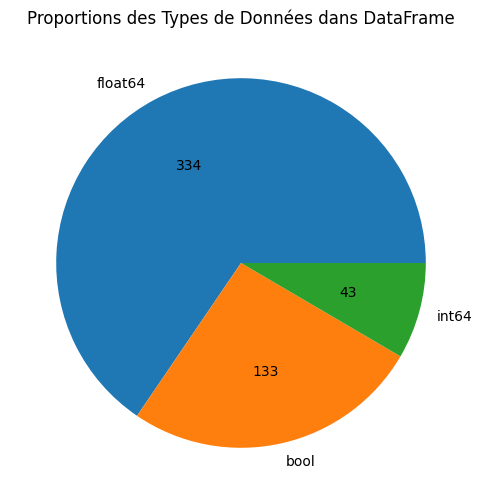

In [13]:
# Graphique pour voir le type de donnée

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
dtype_counts.plot.pie(autopct=lambda p: '{:.0f}'.format(p * sum(dtype_counts) / 100))
plt.title('Proportions des Types de Données dans DataFrame')
plt.ylabel('')  # Pour enlever l'étiquette de la colonne
plt.show()

### One hot encoding colonne boléenne

In [14]:
# Sélectionner les colonnes booléennes
colonnes_bool = base_etude.select_dtypes(include=['bool']).columns

# Effectuer l'encodage one-hot

base_etude_one_hot = base_etude.copy()

base_etude_one_hot[colonnes_bool] = base_etude_one_hot[colonnes_bool].astype(int)

base_etude_one_hot


index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
48744        0      100002            1             0                0   
48745        1      100003            0             0                1   
48746        2      100004            1             1                0   
48747        3      100006            0             0                0   
48748        4      100007            1             0                0   
...        ...         ...          ...           ...              ...   
356250  307506      456251            1             0                1   
356251  307507      456252            0             0                0   
356252  307508      456253            0             0                0   
356253  307509      456254            0             0                0   
356254  307510      456255            0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
48744              0          202500.0    406597.5      24700.5   
48745              0          270000.0   1293502.5      35698.5   
48746              0           67500.0    135000.0       6750.0   
48747              0          135000.0    312682.5      29686.5   
48748              0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          157500.0    254700.0      27558.0   
356251             0           72000.0    269550.0      12001.5   
356252             0          153000.0    677664.0      29979.0   
356253             0          171000.0    370107.0      20205.0   
356254             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
48744          351000.0                    0.018801       -9461   
48745         1129500.0                    0.003541      -16765   
48746          135000.0                    0.010032      -19046   
48747          297000.0                    0.008019      -19005   
48748          513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
356250         225000.0                    0.032561       -9327   
356251         225000.0                    0.025164      -20775   
356252         585000.0                    0.005002      -14966   
356253         319500.0                    0.005313      -11961   
356254         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
48744          -637.0            -3648.0            -2120           1   
48745         -1188.0            -1186.0             -291           1   
48746          -225.0            -4260.0            -2531           1   
48747         -3039.0            -9833.0            -2437           1   
48748         -3038.0            -4311.0            -3458           1   
...               ...                ...              ...         ...   
356250         -236.0            -8456.0            -1982           1   
356251            NaN            -4388.0            -4090           1   
356252        -7921.0            -6737.0            -5150           1   
356253        -4786.0            -2562.0             -931           1   
356254        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
48744                1                0                 1           1   
48745                1                0                 1           1   
48746                1                1                 1           1   
48747                1                0                 1           0   
48748                1                0                 1           0   
...                ...              ...               ...         ...   
356250               1                0                 1           0   
356251               0                0          

In [15]:
# On regarde les types de données de notre dataframe
dtypes = base_etude_one_hot.dtypes
dtype_counts = dtypes.value_counts()
dtype_counts

# Nous pouvons aussi utiliser df.info()

float64    334
int32      133
int64       43
Name: count, dtype: int64

In [16]:
# Identifier les colonnes contenant des valeurs NaN
colonnes_nan = base_etude_one_hot.columns[base_etude_one_hot.isnull().any()].tolist()

print("Colonnes contenant des valeurs NaN :")
for i, col in enumerate(colonnes_nan, 1):
    print(f"{i}. {col}")

type_counts = {}
for col in colonnes_nan:
    col_type = base_etude_one_hot[col].dtype
    type_counts[col_type] = type_counts.get(col_type, 0) + 1

print('='*50)   

print("Compte du type pour les colonnes contenant des valeurs NaN :")
for col_type, count in type_counts.items():
    print(f"{col_type}: {count}")

Colonnes contenant des valeurs NaN :
1. AMT_ANNUITY
2. AMT_GOODS_PRICE
3. DAYS_EMPLOYED
4. CNT_FAM_MEMBERS
5. EXT_SOURCE_2
6. EXT_SOURCE_3
7. OBS_30_CNT_SOCIAL_CIRCLE
8. DEF_30_CNT_SOCIAL_CIRCLE
9. OBS_60_CNT_SOCIAL_CIRCLE
10. DEF_60_CNT_SOCIAL_CIRCLE
11. DAYS_LAST_PHONE_CHANGE
12. AMT_REQ_CREDIT_BUREAU_HOUR
13. AMT_REQ_CREDIT_BUREAU_DAY
14. AMT_REQ_CREDIT_BUREAU_WEEK
15. AMT_REQ_CREDIT_BUREAU_MON
16. AMT_REQ_CREDIT_BUREAU_QRT
17. AMT_REQ_CREDIT_BUREAU_YEAR
18. DAYS_EMPLOYED_PERC
19. INCOME_PER_PERSON
20. ANNUITY_INCOME_PERC
21. PAYMENT_RATE
22. BURO_DAYS_CREDIT_MIN
23. BURO_DAYS_CREDIT_MAX
24. BURO_DAYS_CREDIT_MEAN
25. BURO_DAYS_CREDIT_ENDDATE_MIN
26. BURO_DAYS_CREDIT_ENDDATE_MAX
27. BURO_DAYS_CREDIT_ENDDATE_MEAN
28. BURO_DAYS_CREDIT_UPDATE_MEAN
29. BURO_CREDIT_DAY_OVERDUE_MAX
30. BURO_CREDIT_DAY_OVERDUE_MEAN
31. BURO_AMT_CREDIT_SUM_MAX
32. BURO_AMT_CREDIT_SUM_MEAN
33. BURO_AMT_CREDIT_SUM_SUM
34. BURO_AMT_CREDIT_SUM_DEBT_MAX
35. BURO_AMT_CREDIT_SUM_DEBT_MEAN
36. BURO_AMT_CREDIT_SUM_DE

In [17]:
df_na = base_etude_one_hot.dropna()
df_na

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
48744        0      100002            1             0                0   
48746        2      100004            1             1                0   
48749        5      100008            1             0                0   
48750        6      100009            0             1                0   
48751        7      100010            1             1                0   
...        ...         ...          ...           ...              ...   
356244  307500      456244            0             0                0   
356246  307502      456246            0             0                0   
356247  307503      456247            0             0                0   
356252  307508      456253            0             0                0   
356254  307510      456255            0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
48744              0          202500.0    406597.5      24700.5   
48746              0           67500.0    135000.0       6750.0   
48749              0           99000.0    490495.5      27517.5   
48750              1          171000.0   1560726.0      41301.0   
48751              0          360000.0   1530000.0      42075.0   
...              ...               ...         ...          ...   
356244             0          261000.0   1303812.0      35982.0   
356246             1           94500.0    225000.0      10620.0   
356247             0          112500.0    345510.0      17770.5   
356252             0          153000.0    677664.0      29979.0   
356254             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
48744          351000.0                    0.018801       -9461   
48746          135000.0                    0.010032      -19046   
48749          454500.0                    0.035792      -16941   
48750         1395000.0                    0.035792      -13778   
48751         1530000.0                    0.003122      -18850   
...                 ...                         ...         ...   
356244        1138500.0                    0.031329      -20390   
356246         225000.0                    0.010966      -16063   
356247         247500.0                    0.022800      -11870   
356252         585000.0                    0.005002      -14966   
356254         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
48744          -637.0            -3648.0            -2120           1   
48746          -225.0            -4260.0            -2531           1   
48749         -1588.0            -4970.0             -477           1   
48750         -3130.0            -1213.0             -619           1   
48751          -449.0            -4597.0            -2379           1   
...               ...                ...              ...         ...   
356244        -5326.0             -157.0            -3906           1   
356246        -8736.0            -8672.0            -4531           1   
356247         -399.0             -675.0            -3936           1   
356252        -7921.0            -6737.0            -5150           1   
356254        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
48744                1                0                 1           1   
48746                1                1                 1           1   
48749                1                1                 1           1   
48750                1                0                 1           1   
48751                1                1                 1           0   
...                ...              ...               ...         ...   
356244               1                0                 1           0   
356246               1                1          

In [18]:
df_na.describe()

c:\Users\alex3\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\alex3\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


index     SK_ID_CURR    CODE_GENDER   FLAG_OWN_CAR  \
count  166564.000000  166564.000000  166564.000000  166564.000000   
mean   153794.339371  278225.772124       0.364394       0.387004   
std     88940.686708  102986.840896       0.481261       0.487066   
min         0.000000  100002.000000       0.000000       0.000000   
25%     76633.750000  188865.750000       0.000000       0.000000   
50%    153794.500000  278245.500000       0.000000       0.000000   
75%    230978.250000  367531.250000       1.000000       1.000000   
max    307510.000000  456255.000000       1.000000       1.000000   

       FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count    166564.000000  166564.000000      1.665640e+05  1.665640e+05   
mean          0.311280       0.524177      1.770027e+05  6.141836e+05   
std           0.463018       0.777404      3.028751e+05  3.970278e+05   
min           0.000000       0.000000      2.655000e+04  4.500000e+04   
25%           0.000000       0.000000      1.125000e+05  2.844000e+05   
50%           0.000000       0.000000      1.575000e+05  5.264910e+05   
75%           1.000000       1.000000      2.160000e+05  8.353800e+05   
max           1.000000      19.000000      1.170000e+08  3.375000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  166564.000000     1.665640e+05               166564.000000   
mean    27778.346897     5.518631e+05                    0.020348   
std     14051.261199     3.636099e+05                    0.013261   
min      1980.000000     4.050000e+04                    0.000290   
25%     17266.500000     2.475000e+05                    0.009657   
50%     26064.000000     4.545000e+05                    0.018850   
75%     35653.500000     6.975000e+05                    0.026392   
max    220297.500000     3.375000e+06                    0.072508   

          DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  166564.000000  166564.000000      166564.000000    166564.000000   
mean   -14840.527335   -2510.511881       -4636.395560     -2877.273655   
std      3596.450227    2395.089550        3238.600489      1497.294471   
min    -25200.000000  -17912.000000      -22928.000000     -7197.000000   
25%    -17543.250000   -3340.000000       -6941.000000     -4217.000000   
50%    -14635.000000   -1771.000000       -4275.000000     -2995.000000   
75%    -11930.750000    -835.000000       -1856.000000     -1603.000000   
max     -7676.000000       0.000000           0.000000         0.000000   

       FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count    166564.0   166564.000000    166564.000000     166564.000000   
mean          1.0        0.999964         0.244405          0.999364   
std           0.0        0.006002         0.429735          0.025219   
min           1.0        0.000000         0.000000          0.000000   
25%           1.0        1.000000         0.000000          1.000000   
50%           1.0        1.000000         0.000000          1.000000   
75%           1.0        1.000000         0.000000          1.000000   
max           1.0        1.000000         1.000000          1.000000   

          FLAG_PHONE     FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  166564.000000  166564.000000    166564.000000         166564.000000   
mean        0.287193       0.065638         2.289270              2.061154   
std         0.452454       0.247650         0.949726              0.499930   
min         0.000000       0.000000         1.000000              1.000000   
25%         0.000000       0.000000         2.000000              2.000000   
50%         0.000000       0.000000         2.000000              2.000000   
75%         1.000000       0.000000         3.000000              2.000000   
max         1.000000       1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                1

In [19]:
# Vérifier s'il y a des valeurs infinies
infinite_values = df_na.isin([np.inf, -np.inf]).any().any()
print("Le DataFrame contient des valeurs infinies :", infinite_values)


# Isoler les lignes contenant des valeurs infinies
infinite_rows = df_na[df_na.isin([np.inf, -np.inf]).any(axis=1)]
print("Lignes contenant des valeurs infinies :")
print(infinite_rows)

# Imprimer les valeurs infinies spécifiques
for column in df_na.columns:
    inf_values = df_na[column][df_na[column].isin([np.inf, -np.inf])]
    if not inf_values.empty:
        print(f"Valeurs infinies dans la colonne '{column}':")
        print(inf_values)

Le DataFrame contient des valeurs infinies : True
Lignes contenant des valeurs infinies :
         index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
249830  201086      333092            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
249830             2          117000.0    770292.0      29470.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
249830         688500.0                    0.030755       -9213   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
249830         -229.0            -1507.0            -1870           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
249830               1                0                 1           0   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
249830           0              4.0                     2   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
249830    

In [20]:
# Via la cellule précedente nous observons une ligne avec une valeur infinie, nous supprimerons cette ligne

df_na.drop(index=249830, inplace=True)


C:\Users\alex3\AppData\Local\Temp\ipykernel_19844\1263118253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na.drop(index=249830, inplace=True)


# MLFLOW

In [21]:
from mlflow.models import infer_signature
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.experimental import enable_hist_gradient_boosting


c:\Users\alex3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Préparation de données

### Séparation des données

In [22]:
df_test = df_na.sample(40000)
df_test

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
139255   90511      205083            0             0                0   
328069  279325      423567            0             1                1   
183052  134308      255781            1             1                0   
352783  304039      452261            1             1                0   
344883  296139      443098            0             1                0   
...        ...         ...          ...           ...              ...   
315112  266368      408585            1             1                0   
270132  221388      356454            0             0                0   
336670  287926      433545            0             1                0   
220695  171951      299277            1             1                1   
126444   77700      190086            0             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
139255             1           90000.0    270000.0      13500.0   
328069             1           67500.0    273636.0      27193.5   
183052             1          112500.0   1035832.5      33543.0   
352783             0          157500.0    193572.0      20974.5   
344883             2          126000.0    431280.0      22149.0   
...              ...               ...         ...          ...   
315112             2          252000.0    533668.5      24246.0   
270132             1          135000.0    180000.0       9000.0   
336670             0          112500.0    450000.0      32611.5   
220695             0          315000.0    284256.0      30613.5   
126444             0          135000.0    247500.0      12375.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
139255         270000.0                    0.009334      -12809   
328069         247500.0                    0.025164      -12174   
183052         904500.0                    0.007120      -16643   
352783         171000.0                    0.010147      -14097   
344883         360000.0                    0.018029      -11696   
...                 ...                         ...         ...   
315112         477000.0                    0.018029      -14648   
270132         180000.0                    0.031329      -14769   
336670         450000.0                    0.028663      -10562   
220695         270000.0                    0.032561      -17120   
126444         247500.0                    0.009630      -16377   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
139255        -1742.0            -5864.0            -3944           1   
328069        -2873.0            -6325.0            -3070           1   
183052         -685.0            -1250.0             -190           1   
352783        -1105.0            -2918.0            -4974           1   
344883         -115.0             -469.0            -4324           1   
...               ...                ...              ...         ...   
315112        -1205.0             -140.0            -4846           1   
270132        -3814.0            -2814.0             -223           1   
336670         -332.0            -4956.0            -1302           1   
220695        -2414.0            -5685.0             -632           1   
126444        -3184.0           -10466.0            -4499           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
139255               1                1                 1           1   
328069               1                0                 1           0   
183052               1                0                 1           0   
352783               1                1                 1           1   
344883               1                0                 1           0   
...                ...              ...               ...         ...   
315112               1                0                 1           0   
270132               1                0          

In [23]:
# Load les données data en séparant les caractéristiques (features) et les étiquettes (labels)
X = df_test.drop(columns=['TARGET'],axis=1)
y = df_test['TARGET']

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
from sklearn.datasets import make_classification

make_classification(n_samples=40000,shuffle=True, random_state=None)

(array([[ 1.22370506, -1.4502024 ,  1.20820826, ..., -0.17091267,
          0.44201654, -0.58290184],
        [ 0.34034799,  0.71750527, -0.49513189, ..., -0.81925746,
          0.45212112,  1.06209663],
        [ 0.47629597, -0.22905649,  0.86279044, ..., -0.53041989,
         -0.34283764, -0.37761865],
        ...,
        [ 0.73518983, -1.301573  , -0.01068521, ...,  0.76782451,
         -0.03786375, -1.29533246],
        [-0.53100877, -0.71185067, -1.1628577 , ..., -0.88057539,
         -2.09082679,  1.06506836],
        [ 1.09317849,  0.55754371, -0.13000091, ...,  0.28484788,
         -0.5897443 , -1.34681952]]),
 array([0, 0, 1, ..., 1, 0, 1]))

In [26]:
X_train.shape, X_test.shape

((32000, 509), (8000, 509))

In [27]:
X_train

index  SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
275552  226808      362719            0             1                1   
150020  101276      217582            1             1                1   
222988  174244      301925            0             0                0   
244308  195564      326762            1             1                0   
202819  154075      278570            0             0                0   
...        ...         ...          ...           ...              ...   
283985  235241      372491            0             0                1   
235533  186789      316543            1             0                0   
271218  222474      357705            0             0                0   
332333  283589      428440            0             0                0   
97959    49215      156976            1             1                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
275552             0          540000.0   1288350.0      41692.5   
150020             0          112500.0    534204.0      27265.5   
222988             0          157500.0    450000.0      30073.5   
244308             1          180000.0    331920.0      16096.5   
202819             0          202500.0   1058197.5      38137.5   
...              ...               ...         ...          ...   
283985             0           81000.0    601470.0      30708.0   
235533             0          135000.0    270000.0      13500.0   
271218             1          193500.0    189621.0      15111.0   
332333             0          135000.0    355536.0      17235.0   
97959              0          157500.0    180000.0       9000.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
275552        1125000.0                    0.025164      -14279   
150020         495000.0                    0.002134      -15768   
222988         450000.0                    0.010643       -9607   
244308         225000.0                    0.035792      -15390   
202819         913500.0                    0.004960      -19619   
...                 ...                         ...         ...   
283985         450000.0                    0.035792      -17932   
235533         270000.0                    0.009630      -19788   
271218         144000.0                    0.046220      -17695   
332333         270000.0                    0.030755      -16911   
97959          180000.0                    0.008625       -8839   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
275552        -5083.0            -3001.0            -3316           1   
150020        -3252.0             -679.0            -4326           1   
222988        -2344.0            -9595.0            -2265           1   
244308        -1332.0            -2882.0            -2884           1   
202819        -2391.0            -6176.0            -3159           1   
...               ...                ...              ...         ...   
283985        -1470.0            -2551.0            -1492           1   
235533        -1187.0            -5973.0            -3157           1   
271218         -200.0             -642.0            -1242           1   
332333        -2035.0            -6979.0              -99           1   
97959          -423.0            -3274.0            -1512           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
275552               1                0                 1           0   
150020               1                0                 1           0   
222988               1                1                 1           1   
244308               1                0                 1           1   
202819               1                0                 1           0   
...                ...              ...               ...         ...   
283985               1                0                 1           0   
235533               1                0          

### Pré-traitement des données

In [28]:
# Sélectionner les colonnes à scaler
columns_to_scale = [col for col in X_train.columns if col not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

scaler = preprocessing.StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

### Recherche des hyperparamètres

#### Logistic regression

##### Test paramètre

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Définir les hyperparamètres à rechercher
params = {
    'penalty': ['l1', 'l2'],           # Type de régularisation (l1 = Lasso, l2 = Ridge)  équivaut a liblinear, on peut aussi faire newton-cholesky avec uniquement l2
    'C': [0.01, 0.1, 1.0]        # Paramètre de régularisation inverse (plus C est petit, plus la régularisation est forte)
}

# Créer un modèle LogisticRegression
logistic_regressor = LogisticRegression(solver='liblinear')

# Créer un objet GridSearchCV
gsv = GridSearchCV(logistic_regressor, params,n_jobs=3, cv=5)

# Effectuer la recherche sur la grille sur les données d'entraînement
gsv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=3,
             param_grid={'C': [0.01, 0.1, 1.0], 'penalty': ['l1', 'l2']})

In [30]:
gsv.best_score_, gsv.best_params_

(0.9191874999999999, {'C': 0.01, 'penalty': 'l2'})

In [31]:
gsv.best_estimator_.score(X_test_scaled, y_test)

0.919875

In [32]:
pipeline = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), 
                              ('regressor', LogisticRegression(**gsv.best_params_,solver='liblinear'))])

In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LogisticRegression(C=0.01, solver='liblinear'))])

In [34]:
pipeline.score(X_test, y_test)

0.918625

##### Modification métric

In [35]:
# Defining decision threshold - In this case, the decision threshold used in 20%
decision_threshold = 0.20
# Predicting probability for the test dataset
y_score = pipeline.predict_proba(X_test)

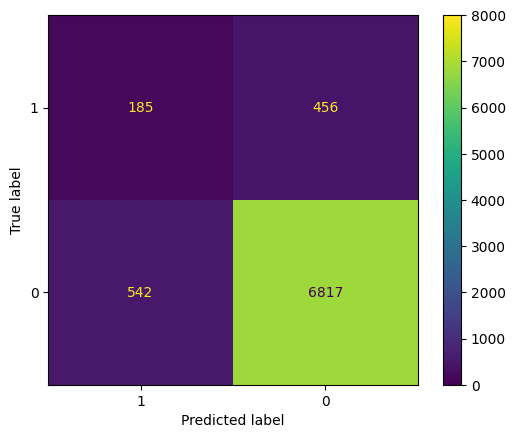

In [36]:
# Creating and displaying confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, (y_score[:,1]>decision_threshold).astype(int),labels=[1, 0])
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[1,0])
disp.plot(cmap="viridis")
disp.im_.set_clim(0, len(y_score))

In [37]:
TP=cm[0,0] # True positive test results
FN=cm[0,1] # False negative test results
FP=cm[1,0] # False positive test results
TN=cm[1,1] # True negative test results
print('Sensitivity : {}%'.format(round(TP/(TP+FN)*100,1)))
print('Specificity : {}%'.format(round(TN/(FP+TN)*100,1)))

Sensitivity : 28.9%
Specificity : 92.6%


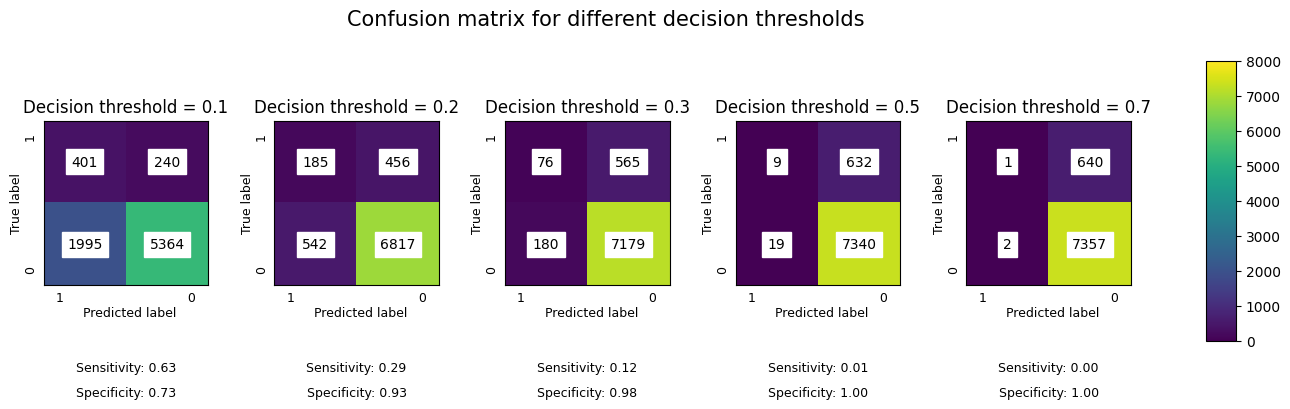

In [38]:
# Comparaison des différents seuils de décision
DecisionThresholds = [0.1, 0.2, 0.3, 0.5, 0.7]

# Prédire les probabilités pour le jeu de test
y_score = pipeline.predict_proba(X_test)

fig, ax = plt.subplots(1, len(DecisionThresholds), figsize=(15, 4))
fig.suptitle('Confusion matrix for different decision thresholds', fontsize=15)

for i, threshold in enumerate(DecisionThresholds):
    cm = confusion_matrix(y_test, (y_score[:, 1] > threshold).astype(int), labels=[1, 0])
    ax[i].set_xlabel('1                               0\n  Predicted label', fontsize=9)
    ax[i].set_ylabel(' True label \n0                               1', fontsize=9)
    ax[i].set_title('Decision threshold = {}'.format(threshold))
    cax = ax[i].matshow(cm, cmap="viridis", vmin=0, vmax=len(y_score))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    for j in range(2):
        for k in range(2):
            ax[i].text(x=j, y=k, s=cm[k, j], va='center', ha='center', bbox=dict(color='white'))
    
    # Calculer la sensibilité et la spécificité
    TP = cm[0, 0]  # True positive
    FN = cm[0, 1]  # False negative
    FP = cm[1, 0]  # False positive
    TN = cm[1, 1]  # True negative
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (FP + TN) if (FP + TN) > 0 else 0
    
    # Ajouter la sensibilité et la spécificité au sous-graphe
    ax[i].text(0.5, 2.5, f'Sensitivity: {sensitivity:.2f}', fontsize=9, ha='center', va='center')
    ax[i].text(0.5, 2.8, f'Specificity: {specificity:.2f}', fontsize=9, ha='center', va='center')

# Ajuster les limites pour bien voir les textes
plt.subplots_adjust(hspace=0.4, wspace=0.4, right=0.85)

# Ajouter une barre de couleur à droite
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(cax, cax=cbar_ax)
plt.show()

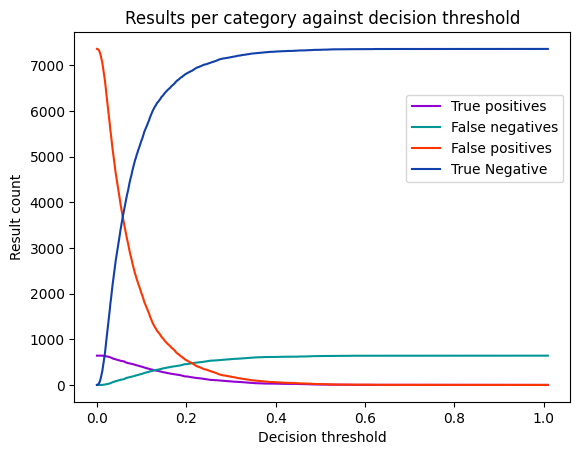

In [39]:
# Creating an array of decision thresholds
ThresholdVector = np.arange(0, 1.01, 0.001)

# Computing the corresponding test results
TPVector = np.empty(0)
FNVector = np.empty(0)
FPVector = np.empty(0)
TNVector = np.empty(0)
for threshold in ThresholdVector:
    cm = confusion_matrix(y_test, (y_score[:,1]>threshold).astype(int),labels=[1, 0])
    TP=cm[0,0] # True positive test results
    FN=cm[0,1] # False negative test results
    FP=cm[1,0] # False positive test results
    TN=cm[1,1] # True negative test results
    TPVector = np.append(TPVector, TP)
    FNVector = np.append(FNVector, FN)
    FPVector = np.append(FPVector, FP)
    TNVector = np.append(TNVector, TN)

# Ploting the results
import matplotlib.pyplot as plt
plt.plot(ThresholdVector, TPVector,color = '#9200D2',label = "True positives")
plt.plot(ThresholdVector, FNVector,color = '#009698',label = "False negatives")
plt.plot(ThresholdVector, FPVector,color = '#FD3500',label = "False positives")
plt.plot(ThresholdVector, TNVector,color = '#1240AA',label = "True Negative")
plt.legend(bbox_to_anchor=(1, 0.85))
plt.xlabel("Decision threshold")
plt.ylabel("Result count")
plt.title("Results per category against decision threshold")
plt.show()

##### Nouvelle métric


###### Création métric

In [40]:
from sklearn.metrics import make_scorer

def custom_metric(y_true, y_pred):
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Calculer la métrique personnalisée
    cost = fp * 5 + fn
    max_cost_LR = max((fp + tn) * 5, (fn + tp))
    score_metric = (max_cost_LR-cost)/max_cost_LR
    return score_metric

# Cette metric doit être le plus haut possible pour privilégier les faux négatifs par rapport aux faux positifs

# Créer le scoreur avec make_scorer
custom_score = make_scorer(custom_metric, greater_is_better=True) # True dit que plus le score est haut mieux c'est


In [41]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipeline,X_test, y_test,cv=3,scoring=custom_score)

array([0.97757848, 0.98002446, 0.97847534])

###### Modification metric

In [42]:
grid = GridSearchCV(logistic_regressor, params,n_jobs=3, cv=5,
                    scoring=custom_score)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=3,
             param_grid={'C': [0.01, 0.1, 1.0], 'penalty': ['l1', 'l2']},
             scoring=make_scorer(custom_metric, response_method='predict'))

In [43]:
best_model_LR = grid.best_estimator_

In [54]:
grid.best_score_, grid.best_params_

(0.9824165353371823, {'C': 0.01, 'penalty': 'l2'})

In [44]:
y_pred = best_model_LR.predict(X_test)

custom_metric(y_test, y_pred)

0.9825791547764642

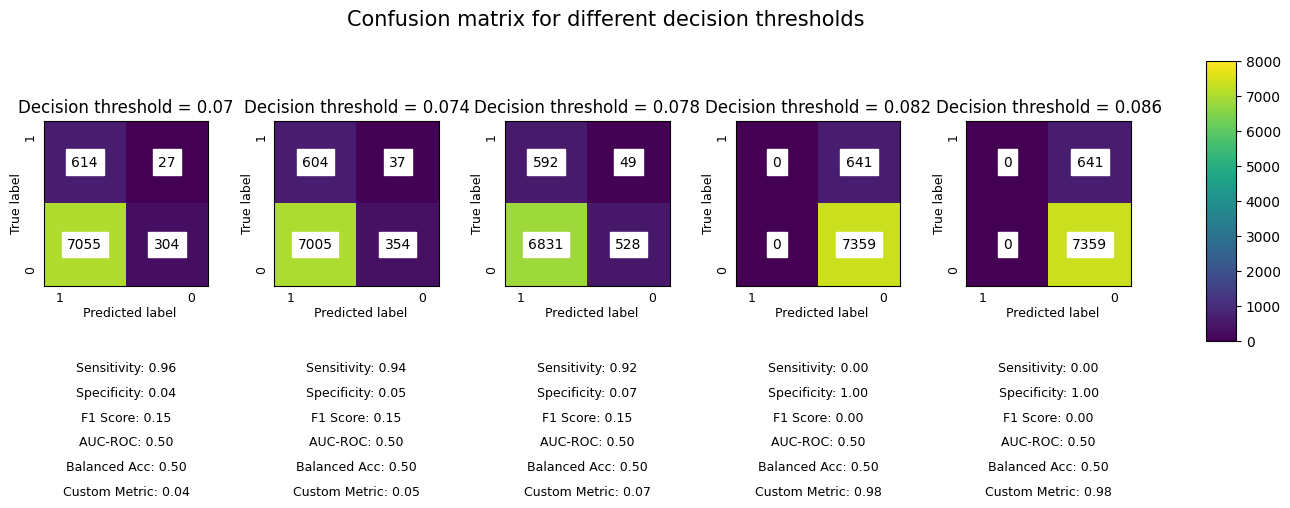

In [52]:
from sklearn.metrics import confusion_matrix, fbeta_score, roc_auc_score, balanced_accuracy_score, make_scorer

# Comparaison des différents seuils de décision
DecisionThresholds = np.arange(0.07,0.09,0.004)

# Prédire les probabilités pour le jeu de test
y_score_metric_LR = best_model_LR.predict_proba(X_test)

fig, ax = plt.subplots(1, len(DecisionThresholds), figsize=(15, 4))
fig.suptitle('Confusion matrix for different decision thresholds', fontsize=15)

for i, threshold in enumerate(DecisionThresholds):
    y_pred_threshold = (y_score_metric_LR[:, 1] > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold, labels=[1, 0])
    ax[i].set_xlabel('1                               0\n  Predicted label', fontsize=9)
    ax[i].set_ylabel(' True label \n0                               1', fontsize=9)
    ax[i].set_title('Decision threshold = {}'.format(round(threshold, 3)))
    cax = ax[i].matshow(cm, cmap="viridis", vmin=0, vmax=len(y_score_metric_LR))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    for j in range(2):
        for k in range(2):
            ax[i].text(x=j, y=k, s=cm[k, j], va='center', ha='center', bbox=dict(color='white'))
    
    # Calculer la sensibilité et la spécificité
    TP = cm[0, 0]  # True positive
    FN = cm[0, 1]  # False negative
    FP = cm[1, 0]  # False positive
    TN = cm[1, 1]  # True negative
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (FP + TN) if (FP + TN) > 0 else 0
    
    # Calculer les autres métriques
    f1_score = fbeta_score(y_test, y_pred_threshold, beta=1.0)
    auc_roc = roc_auc_score(y_test, y_score_metric_LR[:, 1])
    balanced_acc = balanced_accuracy_score(y_test, y_pred_threshold)
    custom_metric_LR = custom_metric(y_test, y_pred_threshold)
    
    # Ajouter les métriques au sous-graphe
    ax[i].text(0.5, 2.5, f'Sensitivity: {sensitivity:.2f}', fontsize=9, ha='center', va='center')
    ax[i].text(0.5, 2.8, f'Specificity: {specificity:.2f}', fontsize=9, ha='center', va='center')
    ax[i].text(0.5, 3.1, f'F1 Score: {f1_score:.2f}', fontsize=9, ha='center', va='center')
    ax[i].text(0.5, 3.4, f'AUC-ROC: {auc_roc:.2f}', fontsize=9, ha='center', va='center')
    ax[i].text(0.5, 3.7, f'Balanced Acc: {balanced_acc:.2f}', fontsize=9, ha='center', va='center')
    ax[i].text(0.5, 4.0, f'Custom Metric: {custom_metric_LR:.2f}', fontsize=9, ha='center', va='center')

# Ajuster les limites pour bien voir les textes
plt.subplots_adjust(hspace=0.4, wspace=0.4, right=0.85)

# Ajouter une barre de couleur à droite
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(cax, cax=cbar_ax)
plt.show()

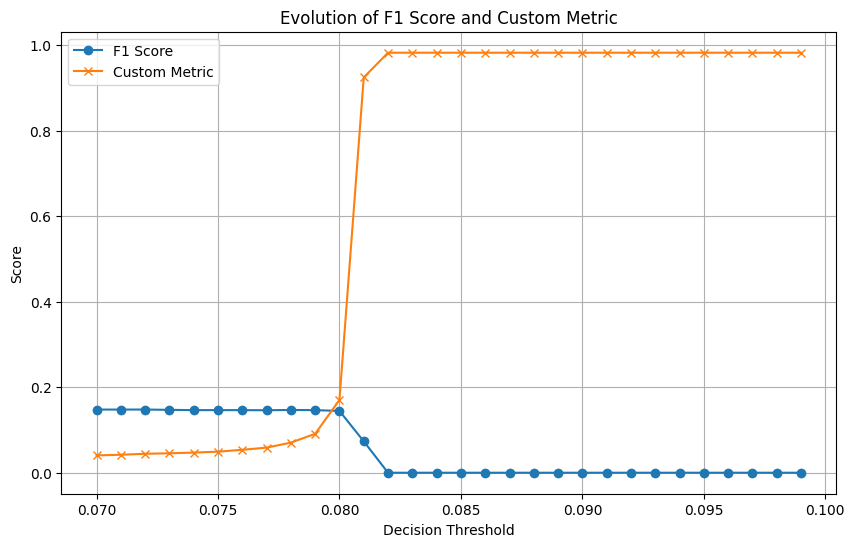

In [56]:
# Comparaison des différents seuils de décision
DecisionThresholds = np.arange(0.07, 0.1, 0.001)

# Prédire les probabilités pour le jeu de test
y_score_metric_LR = best_model_LR.predict_proba(X_test)

f1_scores = []
custom_metrics = []

for threshold in DecisionThresholds:
    y_pred_threshold = (y_score_metric_LR[:, 1] > threshold).astype(int)
    
    # Calculer le F1 Score
    f1 = fbeta_score(y_test, y_pred_threshold, beta=1.0)
    f1_scores.append(f1)
    
    # Calculer la métrique personnalisée
    custom_metric_LR = custom_metric(y_test, y_pred_threshold)
    custom_metrics.append(custom_metric_LR)

# Tracer les courbes
plt.figure(figsize=(10, 6))
plt.plot(DecisionThresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(DecisionThresholds, custom_metrics, label='Custom Metric', marker='x')

plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Evolution of F1 Score and Custom Metric')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
import joblib

joblib.dump(pipeline, 'pipeline_credit_LR.joblib')

['pipeline_credit_LR.joblib']

## 2 - Déploiement d'un modèle sklearn avec MLflow

In [47]:
from mlflow.models.signature import infer_signature

In [48]:
signature = infer_signature(X_train, y_train)

c:\Users\alex3\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


### Sauvegarde du modèle sklearn

In [49]:
import mlflow.sklearn

In [50]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

MlflowException: Path 'mlflow_model' already exists and is not empty

### Code site internet MLFLOW

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score

decision_threshold=0.7

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_proba_pred = (y_score[:,1]>decision_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_proba_pred)
print(accuracy)
# Calculer le F1 score
f1 = f1_score(y_test, y_proba_pred)
print(f1)
# Calculer le ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba_pred)
print(roc_auc)
# Calculer la balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_proba_pred)
print(balanced_acc)

0.91475
0.0
0.5
0.5


In [ ]:
# Création nouvelle métric



In [ ]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="https://localhost:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflowpremier test")

mlflow.sklearn.autolog()

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for credit data")

    # Infer the model signature
    signature = infer_signature(X_train, pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="credit_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )


MlflowException: API request to https://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPSConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=MLflowpremier+test (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000026E7363D690>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))